In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# https://www.sktime.net/en/v0.24.1/examples/transformation/rocket.html
from sktime.datatypes import check_raise, convert_to
from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate, MultiRocketMultivariate
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.transformations.series.impute import Imputer
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.classification.ensemble import ComposableTimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from sktime.utils.plotting import plot_series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV, RidgeCV, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import ipywidgets as widgets
import numpy as np
import glob
import pandas as pd
import os
from sktime.pipeline import make_pipeline

In [6]:
def load_individual_instance(filename, needed_columns):
    df = pd.read_csv(filename)
    for col in needed_columns:
         if not (col in df.columns):
            df[col] = 0.0
    # Ensure all the columns are in the correct order
    return df[needed_columns]    

In [7]:
def create_combined_data(base_dir, filenames, needed_columns):
    combined_data_m = map(lambda file: load_individual_instance(base_dir + "/" + file, needed_columns), filenames)
    combined_data = list(combined_data_m)
    print("Check data: ",check_raise(combined_data, mtype="df-list")) 
    return combined_data

In [8]:
def single_metric_value(m, divisor):
    f = np.floor(m/divisor)
    if (f < 0):
        return 0.0
    else:
        return f

In [9]:
def read_data_all(results_directory, mfile):
    data_files = list(map(os.path.basename, sorted(glob.glob(results_directory + "/MODELFILE*"))))
    metrics = pd.read_csv(mfile)
    return data_files, metrics

In [10]:
def read_data(results_directory, mfile):
    data_files = list(map(os.path.basename, sorted(glob.glob(results_directory + "/MODELFILE*"))))
    metrics = pd.read_csv(mfile)
    # Filter the files because some are missing metrics - why?
    data_files_include = list(filter(lambda n: bool(metrics["testName"].str.contains(n).any()), data_files))
    return data_files_include, metrics

In [39]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

def tsfresh_windowed_regression(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, col_names):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))

    # How to load the custom features

    feature_name = "jrh_windowed_features_calculation"
    settings = {}
    settings[feature_name] = None    # No params
    features_selected = list(map(lambda col_name: col_name + "__" + feature_name, col_names))
    print("features_selected = " + str(features_selected))
    t_features = TSFreshFeatureExtractor(default_fc_parameters=settings, kind_to_fc_parameters=features_selected, show_warnings=False)
    gregressor = GradientBoostingRegressor(n_estimators=300, max_depth=5)
    pipeline = make_pipeline(t_features, StandardScaler(with_mean=False), gregressor) 
    
    #pipeline = make_pipeline(t_features, RidgeCV(alphas=(0.1, 1.0, 50.0))) 
    pipeline.fit(train_data, metrics_train)
    print("TSFresh fit done!")
    score = pipeline.score(test_data, metrics_test)
    
    print("Score on test data = ",score)
    print("TSFresh score done!")

    predicted_val = pipeline.predict(test_data)
    actual_val = metrics_test
    predicted_vs_actual = pd.DataFrame({'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_val', 'actual_val'])
    return [pipeline, predicted_vs_actual, score]

In [12]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

def tsfresh_features_test(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, col_names):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))

    # How to load the custom features

    feature_name = "jrh_windowed_features_calculation"
    settings = {}
    settings[feature_name] = None    # No params
    features_selected = list(map(lambda col_name: col_name + "__" + feature_name, col_names))
    print("features_selected = " + str(features_selected))
    t_features = TSFreshFeatureExtractor(default_fc_parameters=None, kind_to_fc_parameters=features_selected, show_warnings=False)
    extracted_features = t_features.fit_transform(train_data, metrics_train)

    t_features = TSFreshFeatureExtractor(default_fc_parameters=None, kind_to_fc_parameters=features_selected, show_warnings=False)
    test_features = t_features.fit_transform(test_data, metrics_test)
    
    return extracted_features, test_features

In [13]:
def metricval_to_class(metric_vals, metric_max, metric_min, bin_count):
    bins = np.linspace(metric_min, metric_max, bin_count+1)
    digitized = np.digitize(metric_vals, bins)
    return digitized

In [48]:


def tsfresh_classifier(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, col_names, class_count):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])
   
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))

    if class_count is None:
        train_class = metrics_train
        test_class = metrics_test
    else:
        metric_max = np.max([np.max(metrics_train), np.max(metrics_test)])
        metric_min = np.min([np.min(metrics_train), np.min(metrics_test)])
        train_class = metricval_to_class(metrics_train, metric_max, metric_min, class_count)
        test_class = metricval_to_class(metrics_test, metric_max, metric_min, class_count)
    
    # How to load the custom features

    feature_name = "jrh_windowed_features_calculation"
    settings = {}
    settings[feature_name] = None    # No params
    features_selected = list(map(lambda col_name: col_name + "__" + feature_name, col_names))
    print("features_selected = " + str(features_selected))
    t_features = TSFreshFeatureExtractor(default_fc_parameters=settings, kind_to_fc_parameters=features_selected, show_warnings=False)
    gclassifier = GradientBoostingClassifier(n_estimators=300, max_depth=5)
    pipeline = make_pipeline(t_features, StandardScaler(with_mean=False), gclassifier) 
    
    pipeline.fit(train_data, train_class)
    print("TSFresh fit done!")
    score = pipeline.score(test_data, test_class)
    
    print("Score on test data = ",score)
    print("TSFresh score done!")

    predicted_class = pipeline.predict(test_data)
    actual_class = test_class
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class}, columns = ['predicted_class', 'actual_class'])
    return [pipeline, predicted_vs_actual, score]

In [64]:
def tsfresh_classifier_prob(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, col_names, class_count):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])
   
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))

    if class_count is None:
        train_class = metrics_train
        test_class = metrics_test
    else:
        metric_max = np.max([np.max(metrics_train), np.max(metrics_test)])
        metric_min = np.min([np.min(metrics_train), np.min(metrics_test)])
        train_class = metricval_to_class(metrics_train, metric_max, metric_min, class_count)
        test_class = metricval_to_class(metrics_test, metric_max, metric_min, class_count)
    
    # How to load the custom features

    feature_name = "jrh_windowed_features_calculation"
    settings = {}
    settings[feature_name] = None    # No params
    features_selected = list(map(lambda col_name: col_name + "__" + feature_name, col_names))
    print("features_selected = " + str(features_selected))
    t_features = TSFreshFeatureExtractor(default_fc_parameters=settings, kind_to_fc_parameters=features_selected, show_warnings=False)
    gclassifier = GradientBoostingClassifier(n_estimators=300, max_depth=5)
    pipeline = make_pipeline(t_features, StandardScaler(with_mean=False), gclassifier) 
    
    pipeline.fit(train_data, train_class)
    print("TSFresh fit done!")
    score = pipeline.score(test_data, test_class)
    
    print("Score on test data = ",score)
    print("TSFresh score done!")

    predicted_class = pipeline.predict(test_data)
    predicted_class_probs = pipeline.predict_proba(test_data)
    actual_class = test_class
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class}, columns = ['predicted_class', 'actual_class'])
    return [pipeline, predicted_vs_actual, score, predicted_class_probs]

In [16]:
base_dir = "./temp-data-pal-multimodels/"
metric_name = "M1_countObjectsDelivered"
needed_columns = ['dosAttackTrigger', 'distortBaseScanPMB2', 'distortBaseScanOmni', 'distortBaseScanTiago', 'packetLossLaserScanOmni', 'packetLossLaserScanPMB2', 'packetLossLaserScanTiago', 'delayBaseScanOmni', 'delayBaseScanPMB2', 'delayBaseScanTiago1']
mfile = base_dir + "metrics.csv"
rocket_num_kernels = 10000

In [17]:
def check_match(data_files, metrics):
    matches = (metrics["testName"] == data_files)
    return all(matches)

In [18]:
data_files, metrics = read_data(base_dir, mfile)

In [49]:
#pd.set_option('display.max_rows', None)

metric_vals = metrics["M1_countObjectsDelivered"]
metrics_max = np.max(metric_vals)
metrics_min = np.min(metric_vals)

class_count = int(np.round(metrics_max))
#class_count = 4

classes = metricval_to_class(metric_vals, metrics_max, metrics_min, class_count)

class_res = pd.DataFrame({"metric_vals":metric_vals, "classes":classes}, columns = ["metric_vals", "classes"])

In [79]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
operations_log = pd.read_csv(base_dir + "/operationAndMetricLog.csv")
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    ftrain, ftest = tsfresh_features_test(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, needed_columns)

All test/train names match OK!
Check data:  True
Check data:  True
[ 6.  8.  7. ...  7.  3. 27.]
Check data format train_metrics:  True
Check data format test_metrics:  True
features_selected = ['dosAttackTrigger__jrh_windowed_features_calculation', 'distortBaseScanPMB2__jrh_windowed_features_calculation', 'distortBaseScanOmni__jrh_windowed_features_calculation', 'distortBaseScanTiago__jrh_windowed_features_calculation', 'packetLossLaserScanOmni__jrh_windowed_features_calculation', 'packetLossLaserScanPMB2__jrh_windowed_features_calculation', 'packetLossLaserScanTiago__jrh_windowed_features_calculation', 'delayBaseScanOmni__jrh_windowed_features_calculation', 'delayBaseScanPMB2__jrh_windowed_features_calculation', 'delayBaseScanTiago1__jrh_windowed_features_calculation']


Feature Extraction: 100%|██████████████████| 3200/3200 [00:04<00:00, 777.16it/s]


In [6]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
operations_log = pd.read_csv(base_dir + "/operationAndMetricLog.csv")
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    rocket_reg, predicted_vs_actual, score = tsfresh_windowed_regression(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, needed_columns)
    predicted_vs_actual

NameError: name 'read_data' is not defined

In [60]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)

class_count = None

operations_log = pd.read_csv(base_dir + "/operationAndMetricLog.csv")
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    rocket_reg, predicted_vs_actual, score, predicted_class_probs = tsfresh_classifier(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, needed_columns, class_count)
    predicted_vs_actual

All test/train names match OK!
Check data:  True
Check data:  True
Check data format train_metrics:  True
Check data format test_metrics:  True
features_selected = ['dosAttackTrigger__jrh_windowed_features_calculation', 'distortBaseScanPMB2__jrh_windowed_features_calculation', 'distortBaseScanOmni__jrh_windowed_features_calculation', 'distortBaseScanTiago__jrh_windowed_features_calculation', 'packetLossLaserScanOmni__jrh_windowed_features_calculation', 'packetLossLaserScanPMB2__jrh_windowed_features_calculation', 'packetLossLaserScanTiago__jrh_windowed_features_calculation', 'delayBaseScanOmni__jrh_windowed_features_calculation', 'delayBaseScanPMB2__jrh_windowed_features_calculation', 'delayBaseScanTiago1__jrh_windowed_features_calculation']


Feature Extraction:  15%|██▌              | 1921/12800 [00:03<00:19, 555.11it/s]


KeyboardInterrupt: 

In [66]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)

class_count = None

operations_log = pd.read_csv(base_dir + "/operationAndMetricLog.csv")
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    rocket_reg, predicted_vs_actual, score, predicted_class_probs = tsfresh_classifier_prob(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, needed_columns, class_count)
    predicted_vs_actual

All test/train names match OK!
Check data:  True
Check data:  True
Check data format train_metrics:  True
Check data format test_metrics:  True
features_selected = ['dosAttackTrigger__jrh_windowed_features_calculation', 'distortBaseScanPMB2__jrh_windowed_features_calculation', 'distortBaseScanOmni__jrh_windowed_features_calculation', 'distortBaseScanTiago__jrh_windowed_features_calculation', 'packetLossLaserScanOmni__jrh_windowed_features_calculation', 'packetLossLaserScanPMB2__jrh_windowed_features_calculation', 'packetLossLaserScanTiago__jrh_windowed_features_calculation', 'delayBaseScanOmni__jrh_windowed_features_calculation', 'delayBaseScanPMB2__jrh_windowed_features_calculation', 'delayBaseScanTiago1__jrh_windowed_features_calculation']


Feature Extraction: 100%|████████████████| 12800/12800 [00:17<00:00, 732.56it/s]


TSFresh fit done!


Feature Extraction: 100%|██████████████████| 3200/3200 [00:04<00:00, 753.87it/s]


Score on test data =  0.20625
TSFresh score done!


Feature Extraction: 100%|██████████████████| 3200/3200 [00:04<00:00, 747.23it/s]


In [86]:
np.set_printoptions(threshold=np.inf)
np.round(predicted_class_probs,2)
from sklearn.metrics import top_k_accuracy_score
print(len(predicted_class_probs))
top_k_accuracy_score(predicted_vs_actual["actual_class"], predicted_class_probs, k=2, labels=np.arange(0,26), normalize=True)

320


np.float64(0.296875)

In [42]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import median_absolute_percentage_error

SHORT_MIN_THRESHOLD = 2
test_file_stats = operations_log.loc[operations_log["testID"].isin(data_files_test)]
test_file_stats_minfuzztime = pd.to_numeric(test_file_stats["minFuzzingTime"], errors="coerce")
test_file_stats_fuzztime = pd.to_numeric(test_file_stats["fuzzingTimeSet"], errors="coerce")
vel_ops_count = pd.to_numeric(test_file_stats["vel_ops"], errors="coerce")
rv_ops_count = pd.to_numeric(test_file_stats["rv_ops"], errors="coerce")
colormap = np.array(['b', 'r', 'g', 'purple', 'yellow', 'black', 'grey', 'orange'])
is_short = (test_file_stats_minfuzztime < SHORT_MIN_THRESHOLD).astype(int)
has_multiple_vel_ops = (vel_ops_count > 1).astype(int)
has_multiple_rv_ops = (rv_ops_count > 1).astype(int)
# Color as blue or red depending on the presence of short operation or not
color_code = is_short

/home/jharbin/python-venvs/tsfresh_custom/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


r2_score =  -0.2326605143176108
MSE =  0.9192706258889422
RMSE =  0.9587860167362383


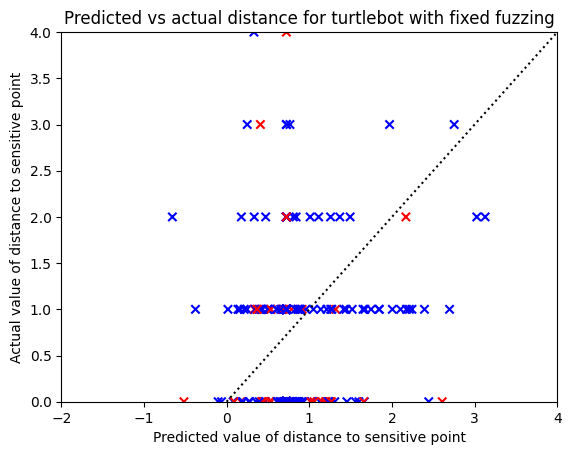

In [43]:
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import MeanSquaredError

mse_c = MeanSquaredError()
rmse_c = MeanSquaredError(square_root=True)

r2_score_val = r2_score(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"], multioutput="uniform_average")
mse_val = mse_c(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"])
rmse_val = rmse_c(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"])
print("r2_score = ", r2_score_val)
print("MSE = ", mse_val)
print("RMSE = ", rmse_val)

plt.scatter(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"], c=colormap[color_code], marker="x")
plt.axline((1,1),(2,2), marker="None", linestyle="dotted", color="Black")
plt.xlabel("Predicted value of distance to sensitive point")
plt.ylabel("Actual value of distance to sensitive point")
plt.xlim([-2, 4.0])
plt.ylim([0, 4.0])
plt.title("Predicted vs actual distance for turtlebot with fixed fuzzing");
plt.savefig("fixedfuzzing_multimodels_twooperations_turtlebot.pdf")

Filtered points count: 255
r2_score =  -3.011593290941091
MSE =  0.9267786714257648
RMSE =  0.9626934462360096


/home/jharbin/python-venvs/tsfresh_custom/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


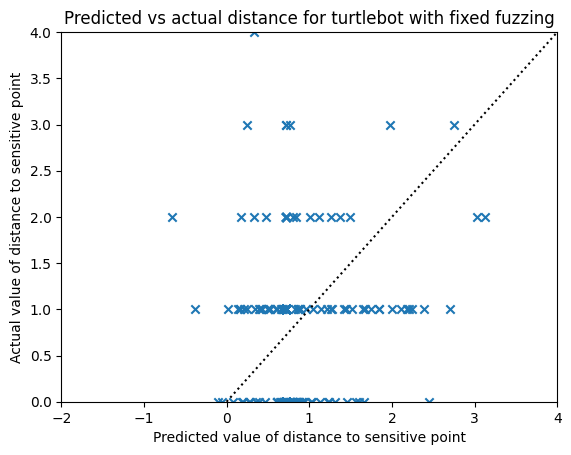

In [44]:
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import MeanSquaredError

bpt = is_short==0
blue_points = predicted_vs_actual.loc[np.array(bpt)]
print("Filtered points count:", len(blue_points))

plt.scatter(blue_points["predicted_val"], blue_points["actual_val"], marker="x")
plt.axline((1,1),(2,2), marker="None", linestyle="dotted", color="Black")
plt.xlabel("Predicted value of distance to sensitive point")
plt.ylabel("Actual value of distance to sensitive point")
plt.xlim([-2, 4.0])
plt.ylim([0, 4.0])
plt.title("Predicted vs actual distance for turtlebot with fixed fuzzing");
#mae = MeanAbsoluteError()
mse_c = MeanSquaredError()
rmse_c = MeanSquaredError(square_root=True)

r2_score_val = r2_score(blue_points["predicted_val"], blue_points["actual_val"])
mse_val = mse_c(blue_points["predicted_val"], blue_points["actual_val"])
rmse_val = rmse_c(blue_points["predicted_val"], blue_points["actual_val"])
print("r2_score = ", r2_score_val)
print("MSE = ", mse_val)
print("RMSE = ", rmse_val)
plt.savefig("fixedfuzzing_multimodels_twooperations_turtlebot_filtered.pdf")

In [51]:
# Allows adjacent classes to be scored as correct
def custom_adjacent_accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_pred - y_true) <= 1) / len(y_pred)

In [52]:
def plot_cm(norm="all"):
    cm = confusion_matrix(predicted_vs_actual["actual_class"], predicted_vs_actual["predicted_class"], normalize=norm)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    

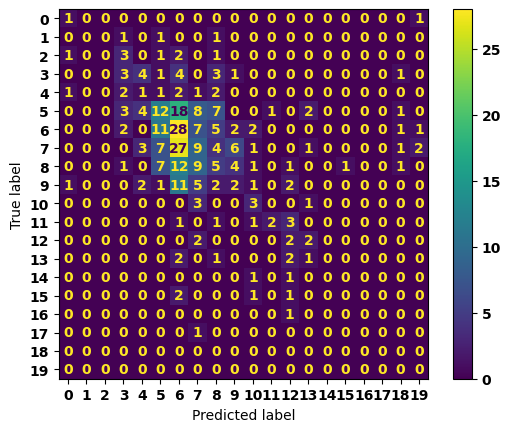

In [53]:
plot_cm(norm=None)

In [47]:
custom_adjacent_accuracy_score(predicted_vs_actual["actual_class"], predicted_vs_actual["predicted_class"])

np.float64(0.48125)

In [125]:
def correct_predictions(pred_vs_actual):
    t = len(pred_vs_actual[(predicted_vs_actual["actual_class"]==pred_vs_actual["predicted_class"])])
    return t